In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [9]:
# Load in csv file
path_to_ssl = '/mnt/c/PythonScripts/segp/github_version/'
relative_path = 'SSL/results/full_data.csv'
fpath = path_to_ssl + relative_path
df = pd.read_csv(fpath, index_col = False)
print(df.columns)

Index(['Models', 'few shot shenzhencxr', 'few shot shenzhencxr uncertainty',
       'few shot montgomerycxr', 'few shot montgomerycxr uncertainty',
       'few shot bach', 'few shot bach uncertainty', 'few shot iChallengeAMD',
       'few shot iChallengeAMD uncertainty', 'few shot iChallengePM',
       'few shot iChallengePM uncertainty', 'few shot chexpert',
       'few shot chexpert uncertainty', 'few shot stoic',
       'few shot stoic uncertainty', 'few shot diabetic retinopathy (5way)',
       'few shot diabetic retinopathy (5way) uncertainty',
       'few shot chestx (5way)', 'few shot chestx (5way) uncertainty',
       'few shot cifar10 (2way)', 'few shot cifar10 (2way) uncertainty',
       'few shot cifar10 (5way)', 'few shot cifar10 (5way) uncertainty',
       'imagenet top1', 'linear chexpert', 'linear diabetic retinopathy',
       'finetune chexpert', 'finetune diabetic retinopathy',
       'attentive diffusion shenzhencxr', 'attentive diffusion montgomerycxr',
       'atten

In [39]:
# Model names
models = ["simclrv1","mocov2","swav","byol","pirl","supervised r50",
        "supervised r18","supervised d121","mimic-chexpert lr=0.01",
        "mimic-chexpert lr=0.1","mimic-chexpert lr=1.0","mimic-cxr r18",
        "mimic-cxr d121"]

# Base dataset names
medical_datasets = ["shenzhencxr","montgomerycxr","bach","iChallengeAMD",
                "iChallengePM","chexpert","stoic","diabetic retinopathy (5way)",
                "chestx (5way)","cifar10 (2way)"]

# All experiment names
experiment_types = ["few shot", "linear", "finetune", "attentive diffusion", 
        "invariance rotation", "invariance hflip", "invariance hue", 
        "perceptual distance alexnet", "perceptual distance vgg",
        "perceptual distance squeezenet"]

def check_if_experiment_exists(df,experiment_type, medical_dataset):
    """Check if an experiment is done with a specific medical dataset"""
    column_name = experiment_type + " " + medical_dataset
    if column_name in df.columns:
        return True
    else:
        return False

def check_which_models_experiment_exists_for(df,column_name):
    experiment = df.loc[:,[column_name]]
    not_contained_indices = experiment.index[experiment.isnull().all(1)].values
    return list(not_contained_indices)

def extract_cleaned_dataframe(df, column_names):
    # column_names should be a list of existing column_names
    new_df = df.loc[:,tuple(column_names)]
    missing_indices = []
    for column in column_names:
        missing_indices = missing_indices + check_which_models_experiment_exists_for(df,column)
    # remove duplicates
    missing_indices = list(set(missing_indices))
    missing_indices.sort(reverse = True)
    for index in missing_indices:
        new_df.drop(index, inplace = True)
    return new_df

def get_few_shot_uncertainty(full_df,list_of_experiment_types, list_of_medical_datasets, column_names):
    if "few shot" in list_of_experiment_types:
        for dataset in list_of_medical_datasets:
            column_name = "few shot " + dataset + " uncertainty"
            if column_name in full_df.columns:
                column_names.append(column_name)
    return column_names

def clean_dataframe(full_df, list_of_experiment_types, list_of_medical_datasets,imagenet = False, models = True):
    """The imagenet keyword decides whether imagenet top1 column is included"""
    column_names = []
    for experiment in list_of_experiment_types:
        for medical_dataset in list_of_medical_datasets:
            if check_if_experiment_exists(full_df,experiment, medical_dataset):
                column_name = experiment + " " + medical_dataset
                column_names.append(column_name)
            else:
                raise KeyError('Problem with the lists given, some combinations do not give valid column names')
    if imagenet:
        column_names.append("imagenet top1")
    if models:
        column_names.append("Models")
    column_names = get_few_shot_uncertainty(full_df,list_of_experiment_types, list_of_medical_datasets, column_names)
    new_df = extract_cleaned_dataframe(full_df, column_names)
    return new_df


clean_df = clean_dataframe(df, ["few shot"], medical_datasets, imagenet = True)
    

Index(['few shot shenzhencxr', 'few shot montgomerycxr', 'few shot bach',
       'few shot iChallengeAMD', 'few shot iChallengePM', 'few shot chexpert',
       'few shot stoic', 'few shot diabetic retinopathy (5way)',
       'few shot chestx (5way)', 'few shot cifar10 (2way)', 'imagenet top1',
       'Models', 'few shot shenzhencxr uncertainty',
       'few shot montgomerycxr uncertainty', 'few shot bach uncertainty',
       'few shot iChallengeAMD uncertainty',
       'few shot iChallengePM uncertainty', 'few shot chexpert uncertainty',
       'few shot stoic uncertainty',
       'few shot diabetic retinopathy (5way) uncertainty',
       'few shot chestx (5way) uncertainty',
       'few shot cifar10 (2way) uncertainty'],
      dtype='object')


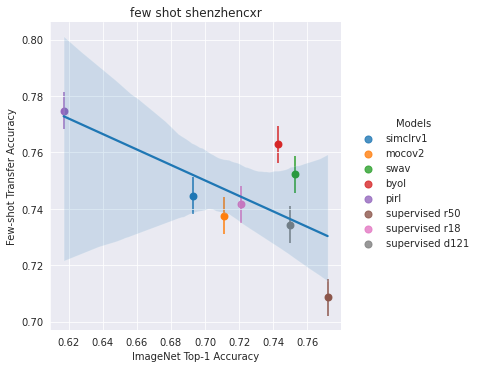

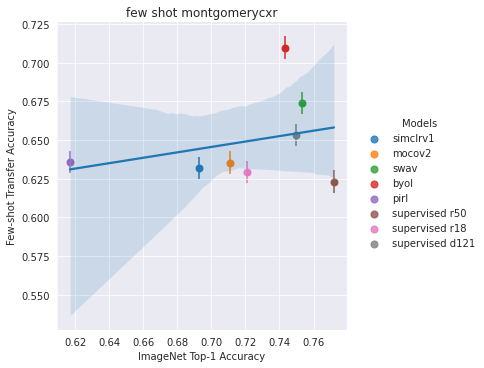

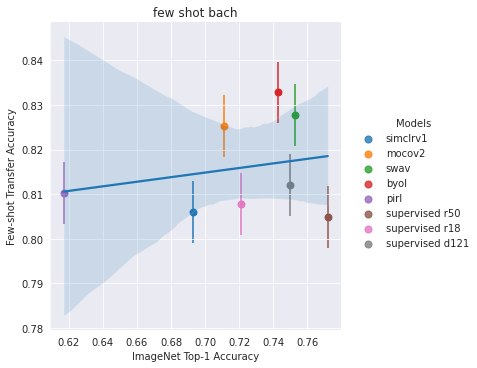

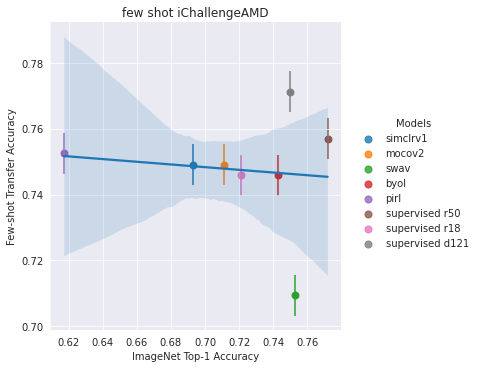

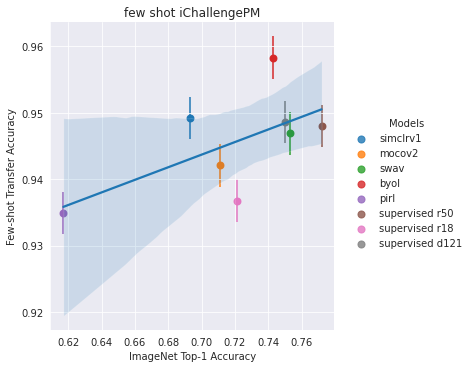

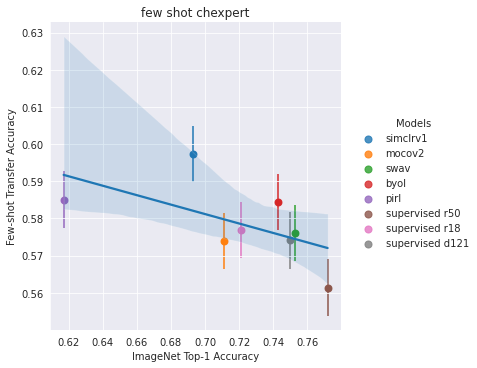

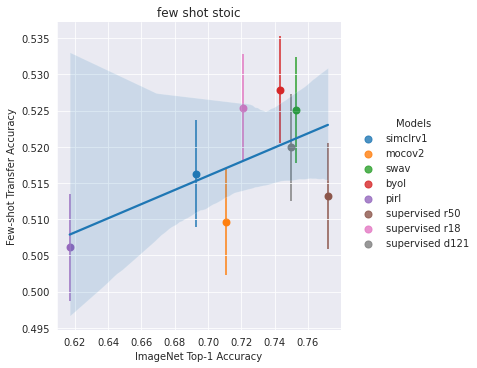

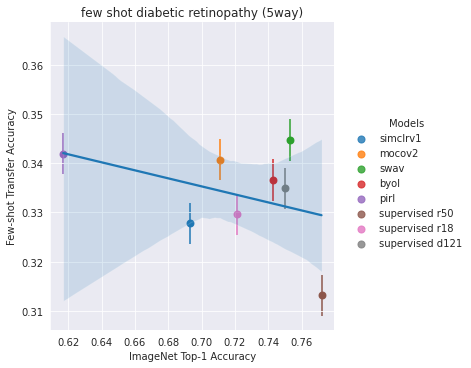

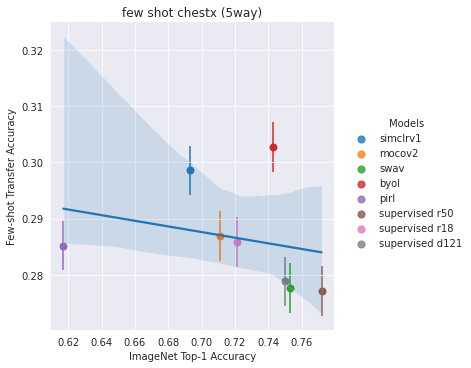

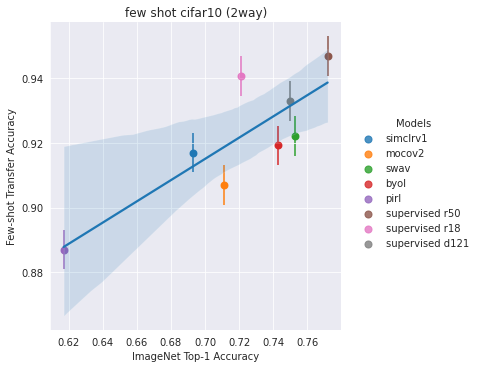

In [40]:
datasets = ['few shot shenzhencxr', 'few shot montgomerycxr', 'few shot bach',
       'few shot iChallengeAMD', 'few shot iChallengePM', 'few shot chexpert',
       'few shot stoic', 'few shot diabetic retinopathy (5way)',
       'few shot chestx (5way)', 'few shot cifar10 (2way)']

for i in range(len(datasets)):
    sns.set_style("darkgrid")
    markers=['x', 'D', 's', '<', '>', 'v', 'X', '+'] #'P'], '4', 'p', '|']
    g = sns.lmplot(x="imagenet top1", y=datasets[i], data=clean_df, fit_reg=False, hue = "Models",palette="tab10", scatter_kws={"s": 50})
    g.map(plt.errorbar,"imagenet top1",datasets[i], yerr=clean_df[datasets[i]+" uncertainty"].to_numpy().mean(), fmt=' ', zorder=-1, label = clean_df["Models"].to_list())
    sns.regplot(x="imagenet top1", y=datasets[i], data=clean_df, scatter=False, ax=g.axes[0, 0])
    plt.ylabel("Few-shot Transfer Accuracy")
    plt.xlabel("ImageNet Top-1 Accuracy")
    plt.title(datasets[i])
    plt.savefig(datasets[i]+"figure.jpg", bbox_inches = "tight")  

ValueError: markers must be a singeton or a list of markers for each level of the hue variable

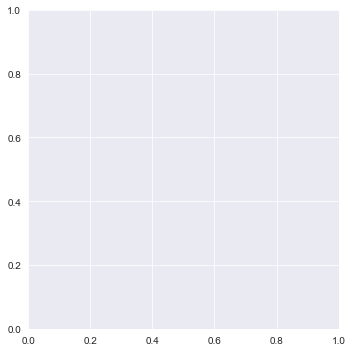

In [ ]:
plot_dset('./few-shot/ichallenge_pm.csv', 'iChallenge-PM')

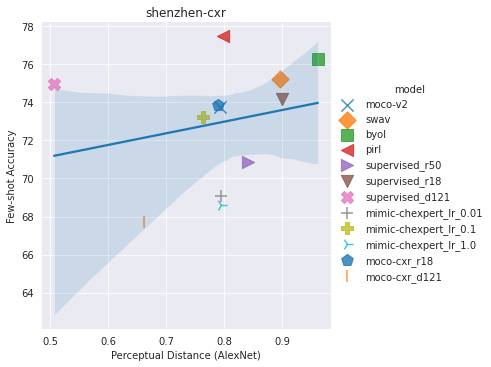

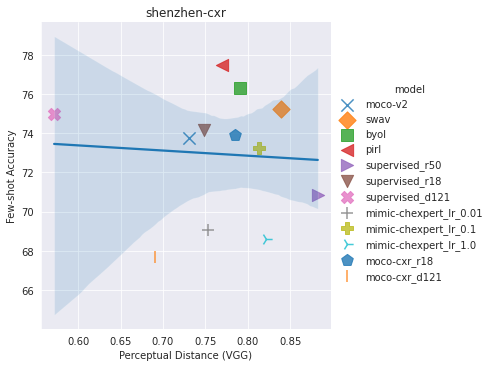

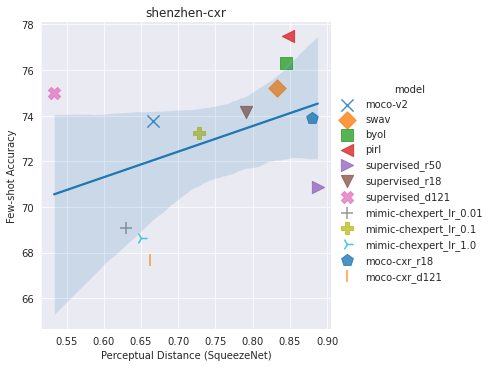

In [ ]:
plot_dset('./few-shot/shenzhencxr.csv', 'shenzhen-cxr')

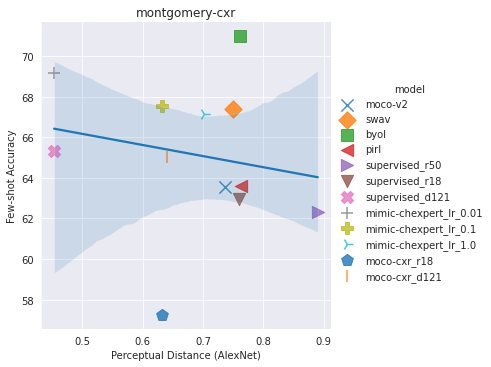

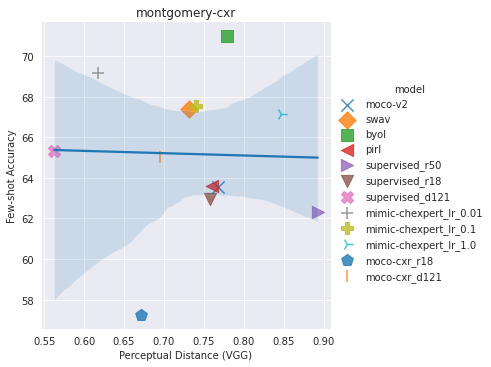

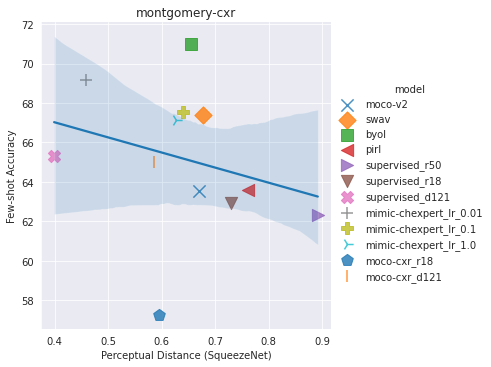

In [ ]:
plot_dset('./few-shot/montgomerycxr.csv', 'montgomery-cxr')

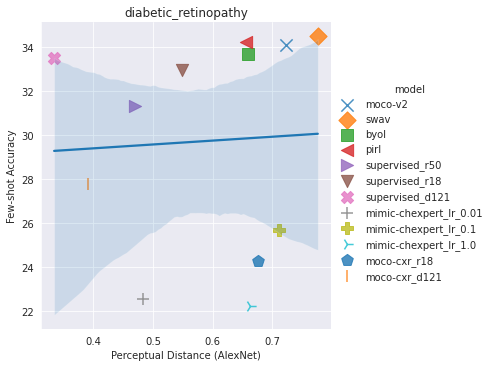

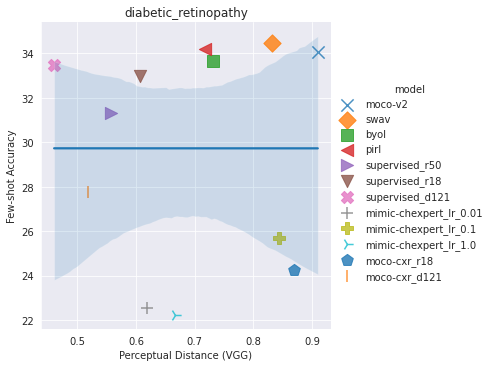

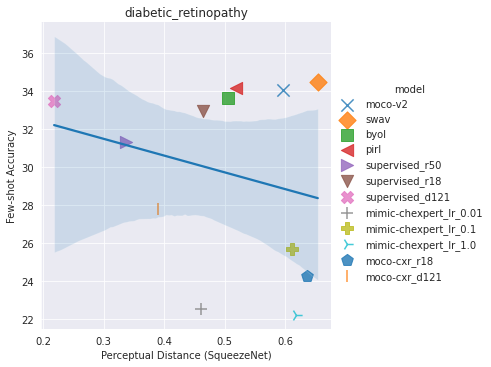

In [ ]:
plot_dset('./few-shot/diabetic_retinopathy.csv', 'diabetic_retinopathy')

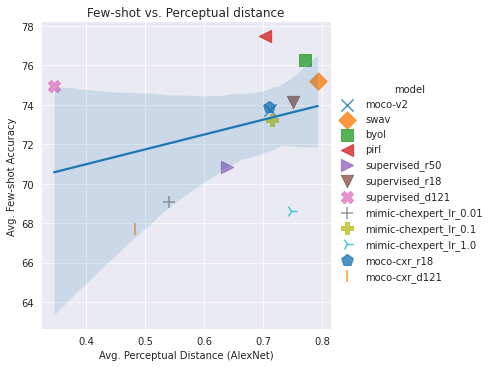

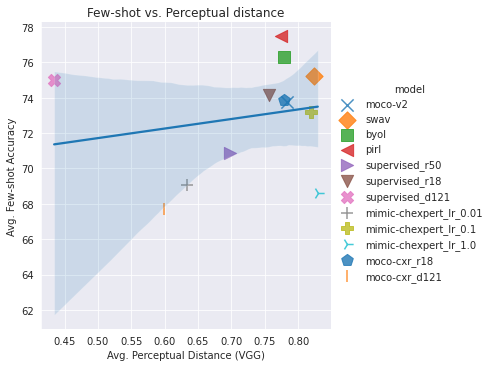

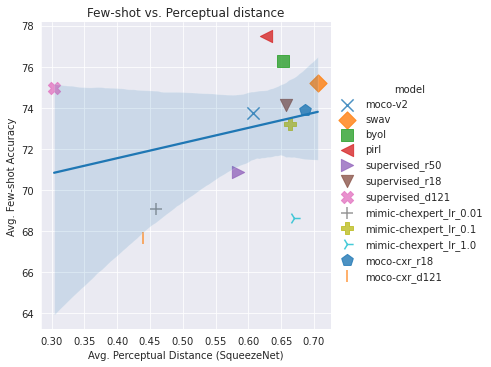

In [ ]:
# plot average across all datasets
dsets = [('diabetic_retinopathy', 'diabetic_retinopathy'), ('ichallenge_amd', 'iChallenge-AMD'),
 ('ichallenge_pm', 'iChallenge-PM') , ('montgomerycxr', 'montgomery-cxr'), ('shenzhencxr', 'shenzhen-cxr')]

average_acc = {}
for i, (dset_name, dset_title) in enumerate(dsets):

    fpath = f'./few-shot/{dset_name}.csv'
    df = pd.read_csv(fpath, index_col=False)
    dset_acc = df.set_index('model').to_dict()['acc']
    for model, acc in dset_acc.items():
        average_acc.setdefault(model, []).append(acc)

for model in average_acc.keys():
    average_acc[model] = np.mean(average_acc[model])



# AlexNet
avg_perceptual_distance_alexnet = {}
for dset, accs in alexnet_dict.items():
    for model, acc in accs.items():
        avg_perceptual_distance_alexnet.setdefault(model, []).append(acc)
for model in avg_perceptual_distance_alexnet.keys():
    avg_perceptual_distance_alexnet[model] = np.mean(avg_perceptual_distance_alexnet[model])


shared_models = dset_acc.keys() and avg_perceptual_distance_alexnet.keys()
dict_intersection = {k: (dset_acc[k], avg_perceptual_distance_alexnet[k]) for k in shared_models}
new_df = pd.DataFrame.from_dict(dict_intersection, orient='index')
new_df = new_df.reset_index(level=0)
new_df.columns = ['model', 'few_shot', 'perceptual_distance']

sns.set_style("darkgrid")
markers=['x', 'D', 's', '<', '>', 'v', 'X', '+', 'P', '4', 'p', '|']
g = sns.lmplot(x="perceptual_distance", y="few_shot", hue="model", data=new_df, fit_reg=False, markers=markers, palette="tab10", scatter_kws={"s": 150})
sns.regplot(x="perceptual_distance", y="few_shot", data=new_df, scatter=False, ax=g.axes[0, 0])
plt.xlabel("Avg. Perceptual Distance (AlexNet)")
plt.ylabel("Avg. Few-shot Accuracy")
plt.title("Few-shot vs. Perceptual distance")
plt.show()




# VGG
avg_perceptual_distance_vgg = {}
for dset, accs in vgg_dict.items():
    for model, acc in accs.items():
        avg_perceptual_distance_vgg.setdefault(model, []).append(acc)
for model in avg_perceptual_distance_vgg.keys():
    avg_perceptual_distance_vgg[model] = np.mean(avg_perceptual_distance_vgg[model])


shared_models = dset_acc.keys() and avg_perceptual_distance_vgg.keys()
dict_intersection = {k: (dset_acc[k], avg_perceptual_distance_vgg[k]) for k in shared_models}
new_df = pd.DataFrame.from_dict(dict_intersection, orient='index')
new_df = new_df.reset_index(level=0)
new_df.columns = ['model', 'few_shot', 'perceptual_distance']

sns.set_style("darkgrid")
markers=['x', 'D', 's', '<', '>', 'v', 'X', '+', 'P', '4', 'p', '|']
g = sns.lmplot(x="perceptual_distance", y="few_shot", hue="model", data=new_df, fit_reg=False, markers=markers, palette="tab10", scatter_kws={"s": 150})
sns.regplot(x="perceptual_distance", y="few_shot", data=new_df, scatter=False, ax=g.axes[0, 0])
plt.xlabel("Avg. Perceptual Distance (VGG)")
plt.ylabel("Avg. Few-shot Accuracy")
plt.title("Few-shot vs. Perceptual distance")
plt.show()




# SqueezeNet
avg_perceptual_distance_squeezenet = {}
for dset, accs in squeezenet_dict.items():
    for model, acc in accs.items():
        avg_perceptual_distance_squeezenet.setdefault(model, []).append(acc)
for model in avg_perceptual_distance_squeezenet.keys():
    avg_perceptual_distance_squeezenet[model] = np.mean(avg_perceptual_distance_squeezenet[model])


shared_models = dset_acc.keys() and avg_perceptual_distance_squeezenet.keys()
dict_intersection = {k: (dset_acc[k], avg_perceptual_distance_squeezenet[k]) for k in shared_models}
new_df = pd.DataFrame.from_dict(dict_intersection, orient='index')
new_df = new_df.reset_index(level=0)
new_df.columns = ['model', 'few_shot', 'perceptual_distance']

sns.set_style("darkgrid")
markers=['x', 'D', 's', '<', '>', 'v', 'X', '+', 'P', '4', 'p', '|']
g = sns.lmplot(x="perceptual_distance", y="few_shot", hue="model", data=new_df, fit_reg=False, markers=markers, palette="tab10", scatter_kws={"s": 150})
sns.regplot(x="perceptual_distance", y="few_shot", data=new_df, scatter=False, ax=g.axes[0, 0])
plt.xlabel("Avg. Perceptual Distance (SqueezeNet)")
plt.ylabel("Avg. Few-shot Accuracy")
plt.title("Few-shot vs. Perceptual distance")
plt.show()



